# 1. Import Packages


In [55]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import seaborn as sns
import pickle
from sklearn.cluster import KMeans

# 2. Prepare Data

Load Data

In [56]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

Drop the ones not needed for submission

In [57]:
df_test = df_test.loc[:1920334]

Separate Labels and Features

In [58]:
# separate labels from features
full_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
                       'TotalTimeStopped_p60','TotalTimeStopped_p80',
                       'TimeFromFirstStop_p20','TimeFromFirstStop_p40','TimeFromFirstStop_p50',
                       'TimeFromFirstStop_p60','TimeFromFirstStop_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p40','DistanceToFirstStop_p50',
                       'DistanceToFirstStop_p60','DistanceToFirstStop_p80']

# relevant label columns used for kaggle challenge
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']

# get label columns
df_train_y = df_train[rel_training_label_cols]

# get data by dropping columns not needed
df_test_X = df_test.drop(columns=['RowId'])
df_train_X = df_train.drop(columns=['RowId']+full_training_label_cols)

Separate Data by City

In [59]:
# train and testing dicts for cities
cities = ['Atlanta','Boston','Chicago','Philadelphia']
city_training_datasets_X = {}
city_training_datasets_y = {}
city_testing_datasets_X = {}

# training
for city in cities:
    # get rows for this city
    city_idxs = (df_train_X['City'] == city).values.nonzero()[0]

    # get X (data) and y (labels)
    city_training_datasets_X[city] = df_train_X.loc[city_idxs]
    city_training_datasets_y[city] = df_train_y.loc[city_idxs]

    # drop the city column from X (data)
    city_training_datasets_X[city] = city_training_datasets_X[city].drop(columns=['City'])

# testing
for city in cities:
    # get rows for this city
    city_idxs = (df_test_X['City'] == city).values.nonzero()[0]

    # get X (data)
    city_testing_datasets_X[city] = df_test_X.loc[city_idxs]

    # drop the city column from X (data)
    city_testing_datasets_X[city] = city_testing_datasets_X[city].drop(columns=['City'])

# 3. Feature Extraction

The intersection IDs act as a feature. Since we separate the data by city, we do not need to encode these and can directly use the ID.

Encode the entry and exit names since they give information on the street size

In [60]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

def encode(x):
    # for missing values encode with a zero
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

for city in cities:
    # encode entry and exit for training
    city_training_datasets_X[city]['EntryTypeStreet'] = city_training_datasets_X[city]['EntryStreetName'].apply(encode)
    city_training_datasets_X[city]['ExitTypeStreet'] = city_training_datasets_X[city]['ExitStreetName'].apply(encode)
    
    # encode entry and exit for testing
    city_testing_datasets_X[city]['EntryTypeStreet'] = city_testing_datasets_X[city]['EntryStreetName'].apply(encode)
    city_testing_datasets_X[city]['ExitTypeStreet'] = city_testing_datasets_X[city]['ExitStreetName'].apply(encode)

Add a binary feature if the entry and exit street are the same

In [61]:
for city in cities:
    city_training_datasets_X[city]["entry_equals_exit"] = (city_training_datasets_X[city]["EntryStreetName"] == city_training_datasets_X[city]["ExitStreetName"]).astype(int)
    city_testing_datasets_X[city]["entry_equals_exit"] = (city_testing_datasets_X[city]["EntryStreetName"] ==  city_testing_datasets_X[city]["ExitStreetName"]).astype(int)

Add a numeric feature to encode the turn based on the entry and exit heading in a circular fashion.

In [62]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

for city in cities:
    city_training_datasets_X[city]['EntryHeading'] = city_training_datasets_X[city]['EntryHeading'].map(directions)
    city_training_datasets_X[city]['ExitHeading'] = city_training_datasets_X[city]['ExitHeading'].map(directions)

    city_testing_datasets_X[city]['EntryHeading'] = city_testing_datasets_X[city]['EntryHeading'].map(directions)
    city_testing_datasets_X[city]['ExitHeading'] = city_testing_datasets_X[city]['ExitHeading'].map(directions)

    city_training_datasets_X[city]['diffHeading'] = city_training_datasets_X[city]['EntryHeading']- city_training_datasets_X[city]['ExitHeading']  
    city_testing_datasets_X[city]['diffHeading'] = city_testing_datasets_X[city]['EntryHeading']- city_testing_datasets_X[city]['ExitHeading']

Add number of possible entries and exits per intersection

In [73]:
X = city_training_datasets_X['Atlanta']

In [74]:
a = X.groupby('IntersectionId')['EntryStreetName'].unique()

In [79]:
a.iloc[1]

array(['Peachtree Street Southwest', 'Mitchell Street Southwest'],
      dtype=object)

Standardize the Longitude and Latitude

In [43]:
m_scaler = MinMaxScaler((-1,1))
s_scaler = StandardScaler()
for city in cities:
    # km_df = city_training_datasets_X[city][['Longitude','Latitude']].copy()
    # kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(km_df)
    # dists = pd.DataFrame(s_scaler.fit_transform(kmeans.transform(km_df)),columns=['d1','d2','d3','d4','d5','d6']).reset_index(drop=True)
    # city_training_datasets_X[city] = pd.concat([city_training_datasets_X[city].reset_index(drop=True),dists],axis=1)

    # km_df = city_testing_datasets_X[city][['Longitude','Latitude']].copy()
    # kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(km_df)
    # dists = pd.DataFrame(s_scaler.fit_transform(kmeans.transform(km_df)),columns=['d1','d2','d3','d4','d5','d6']).reset_index(drop=True)
    # city_testing_datasets_X[city] = pd.concat([city_testing_datasets_X[city].reset_index(drop=True),dists],axis=1)

    city_training_datasets_X[city]['Latitude'] = (m_scaler.fit_transform(city_training_datasets_X[city]['Latitude'].values.reshape(-1, 1)))
    city_training_datasets_X[city]['Longitude'] = (m_scaler.fit_transform(city_training_datasets_X[city]['Longitude'].values.reshape(-1, 1)))
    city_testing_datasets_X[city]['Latitude'] = (m_scaler.fit_transform(city_testing_datasets_X[city]['Latitude'].values.reshape(-1, 1)))
    city_testing_datasets_X[city]['Longitude'] = (m_scaler.fit_transform(city_testing_datasets_X[city]['Longitude'].values.reshape(-1, 1)))

Finally, drop the columns we don't need

In [44]:
for city in cities:
    city_training_datasets_X[city].drop(['EntryStreetName', 'ExitStreetName', 'Path'], axis=1, inplace=True)
    city_testing_datasets_X[city].drop(['EntryStreetName', 'ExitStreetName', 'Path'], axis=1, inplace=True)

Set the data types per column

In [45]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

for city in cities:
    city_training_datasets_X[city] = reduce_mem_usage(city_training_datasets_X[city])
    city_testing_datasets_X[city] = reduce_mem_usage(city_testing_datasets_X[city])

Memory usage of dataframe is 15.52 MB
Memory usage after optimization is: 3.88 MB
Decreased by 75.0%
Memory usage of dataframe is 33.91 MB
Memory usage after optimization is: 8.48 MB
Decreased by 75.0%
Memory usage of dataframe is 17.72 MB
Memory usage after optimization is: 4.43 MB
Decreased by 75.0%
Memory usage of dataframe is 40.59 MB
Memory usage after optimization is: 10.15 MB
Decreased by 75.0%
Memory usage of dataframe is 13.00 MB
Memory usage after optimization is: 3.25 MB
Decreased by 75.0%
Memory usage of dataframe is 29.57 MB
Memory usage after optimization is: 7.39 MB
Decreased by 75.0%
Memory usage of dataframe is 38.70 MB
Memory usage after optimization is: 9.68 MB
Decreased by 75.0%
Memory usage of dataframe is 86.40 MB
Memory usage after optimization is: 21.60 MB
Decreased by 75.0%


Specify the categorical features (needed for training model)

In [46]:
cat_feat = ['Hour', 'Weekend','Month', 'entry_equals_exit', 'IntersectionId',
            'EntryTypeStreet', 'ExitTypeStreet']

rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']
                       

Finally, save the data to disk

In [47]:
with open('../data/basic_training_X.pickle', 'wb') as handle:
    pickle.dump(city_training_datasets_X, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/basic_training_y.pickle', 'wb') as handle:
    pickle.dump(city_training_datasets_y, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/basic_testing_X.pickle', 'wb') as handle:
    pickle.dump(city_testing_datasets_X, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4. Train Models

Load the data

In [48]:
with open('../data/basic_training_X.pickle', 'rb') as handle:
    city_training_datasets_X = pickle.load(handle)

with open('../data/basic_training_y.pickle', 'rb') as handle:
    city_training_datasets_y = pickle.load(handle)

with open('../data/basic_testing_X.pickle', 'rb') as handle:
    city_testing_datasets_X = pickle.load(handle)

Train a model for every city and every target

In [49]:
cities = ['Atlanta','Boston','Chicago','Philadelphia']
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']
cat_feat = ['Hour', 'Weekend','Month', 'entry_equals_exit', 'IntersectionId',
            'EntryTypeStreet', 'ExitTypeStreet']

adv_models = {city: LogisticRegression() for city in cities}
# models = {city: {target : CatBoostRegressor(loss_function='RMSE',iterations=75) for target in rel_training_label_cols} for city in cities}
models = {city: {target : LinearRegression() for target in rel_training_label_cols} for city in cities}

In [50]:
val_preds = []
val_labels = []
cnt = 1
for city in cities:
    # adverserial validation
    training = city_training_datasets_X[city].copy()
    testing = city_testing_datasets_X[city].copy()
    training['target'] = 0
    testing['target'] = 1
    train_test = pd.concat([training, testing], axis = 0)
    target = train_test['target'].values
    train, test = train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)
    train_y = train['target'].values
    test_y = test['target'].values
    train = train.drop('target',axis=1)
    test = test.drop('target',axis=1)
    
    clf = LogisticRegression()
    clf.fit(train,train_y)
    out = clf.predict_proba(test)[:,1]
    print(roc_auc_score(test_y,out))
    out_probs = clf.predict_proba(city_training_datasets_X[city].values)[:,0]
    val_size = int(0.2*len(city_training_datasets_X[city]))
    val_idxs = np.argsort(out_probs)[:val_size]
    train_idxs = np.argsort(out_probs)[val_size:]
    
    for target in rel_training_label_cols:
        print(f"City: {city}, Target: {target} ({cnt}/{len(cities)*len(rel_training_label_cols)})")
        
        X_train = city_training_datasets_X[city].iloc[train_idxs,:]
        y_train = city_training_datasets_y[city][target].values[train_idxs]
        X_validation = city_training_datasets_X[city].iloc[val_idxs,:]
        y_validation = city_training_datasets_y[city][target].values[val_idxs]
        # X_train,X_validation,y_train,y_validation=train_test_split(
        #                                             city_training_datasets_X[city].values,
        #                                             city_training_datasets_y[city][target].values,
        #                                             test_size=0.2, random_state=42)
        models[city][target].fit(X_train,y_train)
        # models[city][target].fit(
        #     X_train, y_train,
        #     cat_features=cat_feat,
        #     eval_set=(X_validation, y_validation),
        #     logging_level='Verbose',  # you can uncomment this for text output
        #     # plot=True
        # )
        val_preds.append(models[city][target].predict(X_validation))
        val_labels.append(y_validation)
        cnt += 1

val_preds = np.concatenate(val_preds)
val_labels= np.concatenate(val_labels)

print(f"Val RMSE: {mean_squared_error(val_labels,val_preds,squared=False)}")

/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.6576507132764144
City: Atlanta, Target: TotalTimeStopped_p20 (1/24)
City: Atlanta, Target: TotalTimeStopped_p50 (2/24)
City: Atlanta, Target: TotalTimeStopped_p80 (3/24)
City: Atlanta, Target: DistanceToFirstStop_p20 (4/24)
City: Atlanta, Target: DistanceToFirstStop_p50 (5/24)
City: Atlanta, Target: DistanceToFirstStop_p80 (6/24)


/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.6575859952728711
City: Boston, Target: TotalTimeStopped_p20 (7/24)
City: Boston, Target: TotalTimeStopped_p50 (8/24)
City: Boston, Target: TotalTimeStopped_p80 (9/24)
City: Boston, Target: DistanceToFirstStop_p20 (10/24)
City: Boston, Target: DistanceToFirstStop_p50 (11/24)
City: Boston, Target: DistanceToFirstStop_p80 (12/24)
0.556426957105883
City: Chicago, Target: TotalTimeStopped_p20 (13/24)
City: Chicago, Target: TotalTimeStopped_p50 (14/24)
City: Chicago, Target: TotalTimeStopped_p80 (15/24)
City: Chicago, Target: DistanceToFirstStop_p20 (16/24)
City: Chicago, Target: DistanceToFirstStop_p50 (17/24)
City: Chicago, Target: DistanceToFirstStop_p80 (18/24)


/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.644205259544096
City: Philadelphia, Target: TotalTimeStopped_p20 (19/24)
City: Philadelphia, Target: TotalTimeStopped_p50 (20/24)
City: Philadelphia, Target: TotalTimeStopped_p80 (21/24)
City: Philadelphia, Target: DistanceToFirstStop_p20 (22/24)
City: Philadelphia, Target: DistanceToFirstStop_p50 (23/24)
City: Philadelphia, Target: DistanceToFirstStop_p80 (24/24)
Val RMSE: 70.6743381739585


Generate Test Predictions

In [51]:
df_sub = pd.read_csv('../submission/sample_submission.csv')

In [52]:
test_preds = []
for city in cities:
    city_df_preds = pd.DataFrame(columns=rel_training_label_cols)
    for target_i,target in enumerate(rel_training_label_cols):
        city_df_preds[target] = models[city][target].predict(city_testing_datasets_X[city])
    
    city_df_preds = city_df_preds.stack()
    city_df_preds = pd.DataFrame(city_df_preds)
    test_preds.append(city_df_preds[0].values)

test_preds = np.concatenate(test_preds)
df_sub['Target'] = test_preds
df_sub.to_csv('../submission/lr_70_67.csv',index=False)

In [26]:
models = []
for i,tc in enumerate(rel_training_label_cols):
    X_train,X_validation,y_train,y_validation=train_test_split(train_set,all_target[i], test_size=0.2, random_state=31)

    model = CatBoostRegressor(
        loss_function='RMSE',
        iterations=200
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_feat,
        eval_set=(X_validation, y_validation),
    #     logging_level='Verbose',  # you can uncomment this for text output
        plot=True
    )
    models.append(model)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.378863
0:	learn: 6.8820235	test: 6.8085650	best: 6.8085650 (0)	total: 226ms	remaining: 45s
1:	learn: 6.7445098	test: 6.6571545	best: 6.6571545 (1)	total: 354ms	remaining: 35s
2:	learn: 6.6695849	test: 6.5658678	best: 6.5658678 (2)	total: 443ms	remaining: 29.1s
3:	learn: 6.6113448	test: 6.4949000	best: 6.4949000 (3)	total: 525ms	remaining: 25.7s
4:	learn: 6.5779315	test: 6.4550264	best: 6.4550264 (4)	total: 632ms	remaining: 24.7s
5:	learn: 6.5436799	test: 6.4178089	best: 6.4178089 (5)	total: 786ms	remaining: 25.4s
6:	learn: 6.5237098	test: 6.3969001	best: 6.3969001 (6)	total: 896ms	remaining: 24.7s
7:	learn: 6.5091259	test: 6.3821344	best: 6.3821344 (7)	total: 939ms	remaining: 22.5s
8:	learn: 6.4923500	test: 6.3624637	best: 6.3624637 (8)	total: 1.05s	remaining: 22.2s
9:	learn: 6.4773681	test: 6.3432744	best: 6.3432744 (9)	total: 1.22s	remaining: 23.1s
10:	learn: 6.4623605	test: 6.3260911	best: 6.3260911 (10)	total: 1.38s	remaining: 23.8s
11:	learn: 6.4545322	test:

In [27]:
import pickle
import pandas as pd
import numpy as np

In [ ]:
# with open('models.pickle', 'wb') as handle:
#     pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('models.pickle', 'rb') as handle:
    models = pickle.load(handle)

In [39]:
preds = []
truths = []
for i in range(6):
    X_train,X_validation,y_train,y_validation=train_test_split(train_set,all_target[i], test_size=0.2, random_state=31)
    preds.append(models[i].predict(X_validation))
    truths.append(y_validation.values)

In [38]:
preds = np.concatenate(preds)
truths = np.concatenate(truths)

In [40]:
np.sqrt(((preds - truths) ** 2).mean())

50.455332345134565

In [30]:
df_test = pd.read_csv('../data/test.csv')

In [31]:
df = pd.read_csv('../submission/sample_submission.csv')

In [40]:

target_ids = df['TargetId'].values

for i,tid in enumerate(target_ids):
    target_ids[i] = tid.split('_')[0]

tids = np.sort(np.unique(target_ids).astype(int))
missing_ids = np.setdiff1d(df_test['RowId'].values,tids)
missing_ids_idxs = np.where(np.isin(df_test['RowId'].values,missing_ids))[0]

In [41]:
X_test_ = X_test.drop(missing_ids_idxs)

In [42]:
preds = []
for model in models:
    preds.append(model.predict(X_test_))

In [43]:
preds_all = np.concatenate(preds)

In [37]:
full_preds = np.zeros(len(preds)*len(preds[0]))
for i,pred in enumerate(preds):
    full_preds[i::6] = pred

In [44]:
df = pd.read_csv('../submission/sample_submission.csv')
df['Target'] = preds_all

In [44]:
df[5::6].mean()

In [47]:
df.to_csv('../submission/basic2.csv',index=False)

In [46]:
df

,TargetId,Target
0,0_0,0.673897
1,0_1,0.357533
2,0_2,-0.130717
3,0_3,0.667677
4,0_4,-0.136937
...,...,...
11522005,1920334_1,218.817100
11522006,1920334_2,210.699236
11522007,1920334_3,222.282460
11522008,1920334_4,223.973268


In [42]:
df2 = pd.read_csv('../submission/basic.csv')

In [58]:
y6_train.values.mean()

84.0

In [61]:
vals = np.sort(y6_train.values)[::-1]

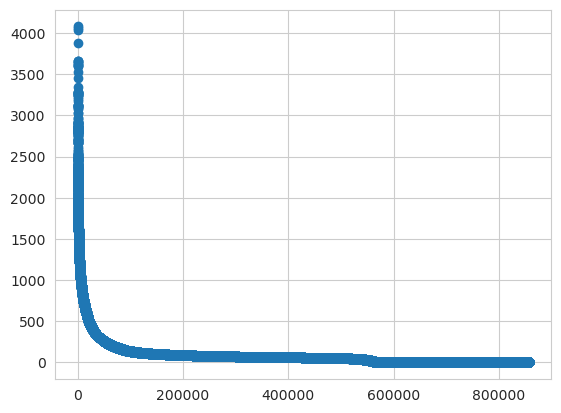

In [67]:
plt.scatter(np.arange(len(vals)),vals)

In [69]:
(vals < 100).mean()

0.8132935226714091

In [29]:
print(y1_train.max())
print(y2_train.max())
print(y3_train.max())
print(y4_train.max())
print(y5_train.max())
print(y6_train.max())

298.0
375.0
763.0
1902.0
2852.0
4080.0
